In [5]:
import pandas as pd
import requests
import json

# URL del archivo JSON en formato RAW
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# Extraer los datos
response = requests.get(url)
data = response.json()

# Convertir a DataFrame
df = pd.json_normalize(data)

print("Datos cargados exitosamente. A continuacion se muestran las primeras 5 filas:")
df.head()

Datos cargados exitosamente. A continuacion se muestran las primeras 5 filas:


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [4]:
#PREPARACION DE LOS DATOS

# 1. Eliminar duplicados
df = df.drop_duplicates()

# 2. Verificación de valores nulos
print("Valores nulos por columna (antes de procesar Churn):\n", df.isnull().sum())

# Convertir 'Churn' a numérico (1 para 'Yes', 0 para 'No')
if 'Churn' in df.columns:
    print("\nUnique values in 'Churn' before conversion (raw):\n", df['Churn'].unique())
    # Convertir a string, limpiar espacios, convertir a minúsculas
    # y luego mapear. Usamos .loc para evitar SettingWithCopyWarning si df es una vista.
    df.loc[:, 'Churn'] = df['Churn'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})
    print("\nValores de Churn después de mapear:\n", df['Churn'].value_counts(dropna=False))

# 3. Eliminar filas con nulos críticos o rellenarlos
# Eliminar filas donde 'customerID' o 'Churn' son nulos
df = df.dropna(subset=['customerID', 'Churn'])

print("\nLimpieza básica completada. Dimensiones actuales:", df.shape)

Valores nulos por columna (antes de procesar Churn):
 customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64

Unique values in 'Churn' before conversion (raw):
 ['No' 'Yes' '']

Valores de Churn después de mapear:
 Churn
0.0    5174
1.0    1869
NaN     224
Name: count, dtype: int64

Limpieza básica completada. Dimensiones actuales: (7043, 21)


In [3]:
# CREACION DE LOS MODELOS PREDICTIVOS

# Eliminar columnas irrelevantes
columns_to_drop = ['customerID']  # Puedes agregar más si detectas otras irrelevantes
df_model = df.drop(columns=columns_to_drop, errors='ignore')

print("Columnas que quedan para el modelo:")
print(df_model.columns)

# Ver proporción de Churn
churn_counts = df_model['Churn'].value_counts()
print("Cantidad por clase:\n", churn_counts)
print("\nProporción por clase:\n", churn_counts / churn_counts.sum())



Columnas que quedan para el modelo:
Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')
Cantidad por clase:
 Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Proporción por clase:
 Churn
No     0.711986
Yes    0.257190
       0.030824
Name: count, dtype: float64


In [2]:
# CREACION DE LOS MODELOS PREDICTIVOS

#Balanceo de clases

import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Recarga de datos para asegurar que el DataFrame no esté vacío
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.json_normalize(data)

# 2. Identificar la columna Churn (buscando el nombre exacto que pone json_normalize)
# Normalmente es 'Churn' o 'customer.Churn'
col_target = [c for c in df.columns if 'churn' in c.lower()][0]
print(f"Columna detectada: {col_target}")

# 3. Conversión de YES/NO a 1/0
# Creamos una copia para no dañar el original
df_model = df.copy()

# Normalizamos el texto (minúsculas y sin espacios)
df_model[col_target] = df_model[col_target].astype(str).str.strip().str.lower()
mapping = {'yes': 1, 'no': 0}
df_model['target'] = df_model[col_target].map(mapping)

# 4. Limpieza de filas sin respuesta (NaN)
df_model = df_model.dropna(subset=['target'])

# 5. Preparación de variables (X) y objetivo (y)
y = df_model['target'].astype(int)
X = df_model.drop(columns=[col_target, 'target'])

# 6. Transformación de X (Dummies y limpieza de nulos)
X = pd.get_dummies(X, drop_first=True)
# Llenamos nulos con 0 para que SMOTE pueda calcular distancias
X = X.fillna(0)

# 7. División y Balanceo con SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\n--- ¡Proceso Exitoso! ---")
print(f"Registros después de SMOTE: {len(X_train_bal)}")
print(f"Distribución de clases:\n{y_train_bal.value_counts()}")

Columna detectada: Churn

--- ¡Proceso Exitoso! ---
Registros después de SMOTE: 8278
Distribución de clases:
target
0    4139
1    4139
Name: count, dtype: int64


Columna detectada: Churn

Distribución de clases antes de SMOTE:
target
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Distribución de clases después de SMOTE:
target
0    0.5
1    0.5
Name: proportion, dtype: float64

--- Regresión Logística ---
Accuracy: 0.7452093683463449
F1-score: 0.5761511216056671

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1035
           1       0.52      0.65      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.75      1409



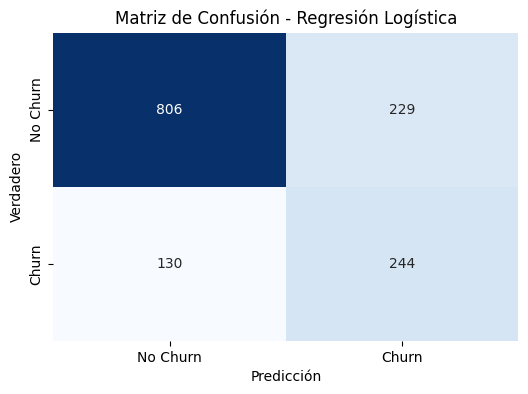


--- Random Forest ---
Accuracy: 0.7920511000709723
F1-score: 0.5947441217150761

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1035
           1       0.62      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409



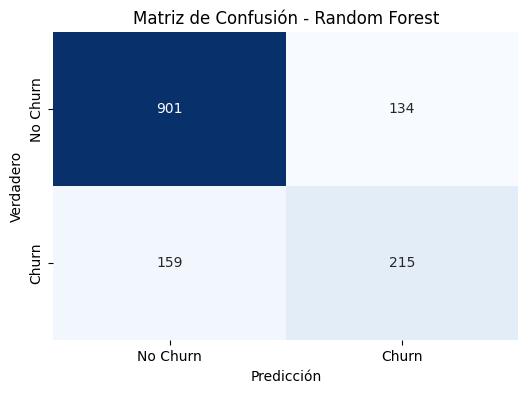


--- Gradient Boosting ---
Accuracy: 0.7693399574166075
F1-score: 0.6189917936694022

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.55      0.71      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409



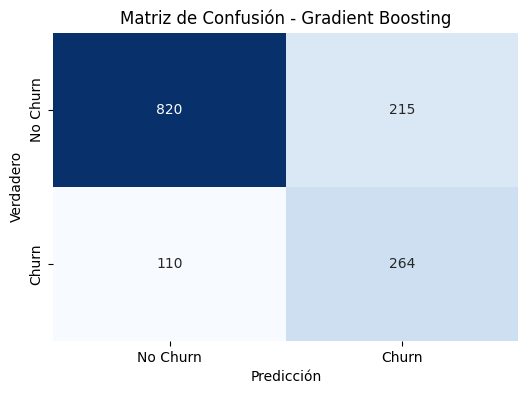

In [8]:
#NORMALIZACION Y ESTANDARIZACION

# -----------------------------
# 1. Librerías
# -----------------------------
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Para modelos y métricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 2. Carga de datos
# -----------------------------
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.json_normalize(data)

# -----------------------------
# 3. Identificar columna target 'Churn'
# -----------------------------
col_target = [c for c in df.columns if 'churn' in c.lower()][0]
print(f"Columna detectada: {col_target}")

# -----------------------------
# 4. Preparación del target
# -----------------------------
df_model = df.copy()
df_model[col_target] = df_model[col_target].astype(str).str.strip().str.lower()
mapping = {'yes': 1, 'no': 0}
df_model['target'] = df_model[col_target].map(mapping)

# Eliminar filas sin respuesta
df_model = df_model.dropna(subset=['target'])

# -----------------------------
# 5. Eliminación de columnas irrelevantes
# -----------------------------
irrelevant_cols = ['customerID']  # Se pueden agregar más si es necesario
X = df_model.drop(columns=[col_target, 'target'] + irrelevant_cols, errors='ignore')
y = df_model['target'].astype(int)

# -----------------------------
# 6. Transformación de variables categóricas y nulos
# -----------------------------
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)

# -----------------------------
# 7. Verificación de proporción de Churn
# -----------------------------
print("\nDistribución de clases antes de SMOTE:")
print(y.value_counts(normalize=True))

# -----------------------------
# 8. División Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 9. Balanceo con SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\nDistribución de clases después de SMOTE:")
print(y_train_bal.value_counts(normalize=True))

# -----------------------------
# 10. Normalización / Estandarización
# -----------------------------
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 11. Entrenamiento de modelos
# -----------------------------
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n--- {name} ---")
    # Entrenar
    model.fit(X_train_bal_scaled, y_train_bal)
    # Predecir
    y_pred = model.predict(X_test_scaled)

    # Evaluar
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Matriz de Confusión - {name}')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicción')
    plt.show()

Usando datos ya cargados en memoria.


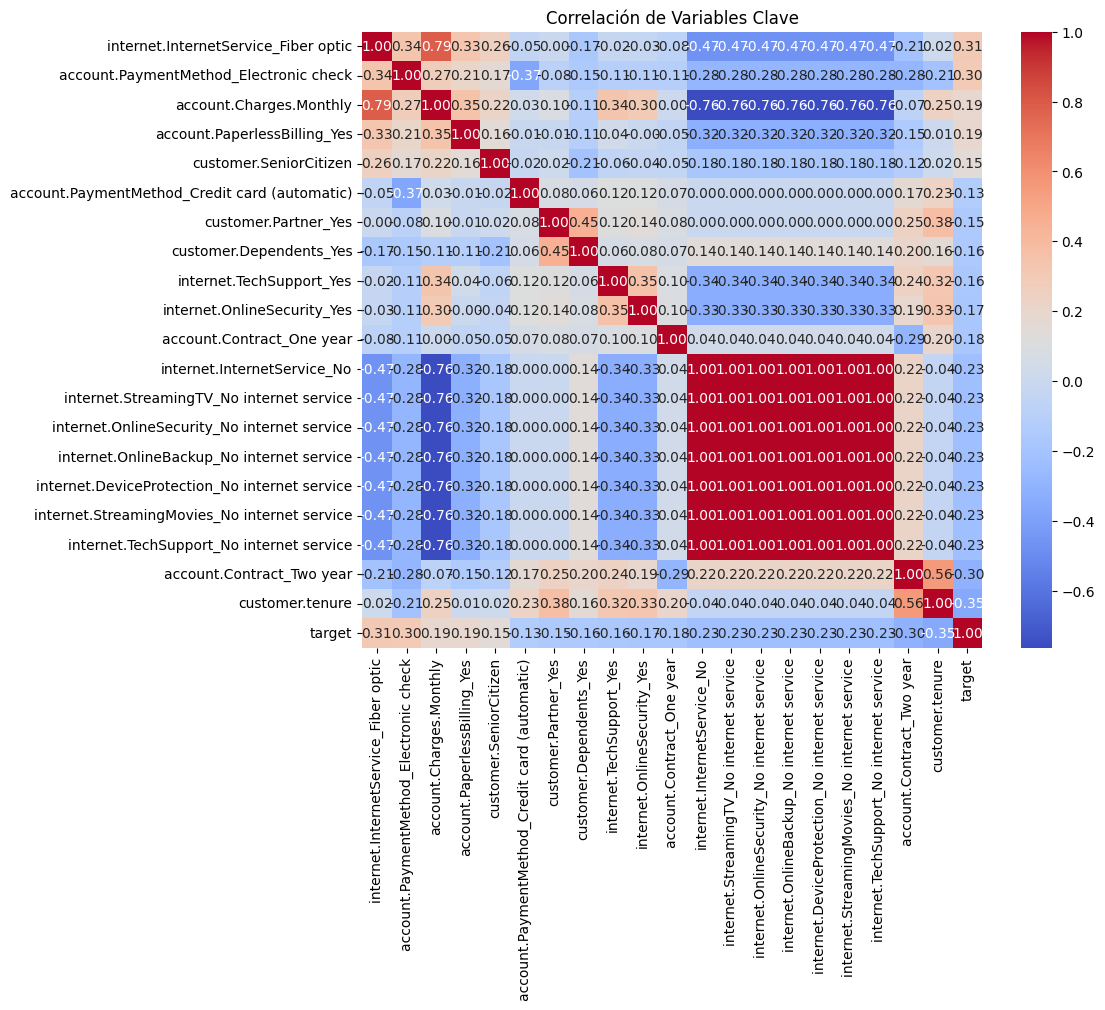

Hecho. Variables seleccionadas: 20


In [7]:
# CORRELACION Y SELECCION DE VARIABLE (análisis de correlacion y análisis dirigido)

import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 2. Carga Optimizada
# -----------------------------
if 'df' not in locals():
    print("Descargando datos...")
    url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
    response = requests.get(url)
    df = pd.json_normalize(response.json())
else:
    print("Usando datos ya cargados en memoria.")

# -----------------------------
# 3. Preparación Rápida
# -----------------------------
col_target = [c for c in df.columns if 'churn' in c.lower()][0]
df_model = df.copy()

# Limpieza rápida de la target
df_model[col_target] = df_model[col_target].astype(str).str.strip().str.lower()
df_model['target'] = df_model[col_target].map({'yes': 1, 'no': 0})
df_model = df_model.dropna(subset=['target'])

# Eliminamos columnas de ID y texto basura ANTES de dummies para ahorrar memoria
# Si una columna tiene demasiados valores únicos y es texto, suele ser un ID
cols_to_drop = [col_target, 'customerID']
for col in df_model.select_dtypes(include=['object']).columns:
    if df_model[col].nunique() > 100: # IDs o nombres
        cols_to_drop.append(col)

# *** FIX: Ensure 'target' column is dropped from X ***
X = df_model.drop(columns=list(set(cols_to_drop + ['target'])), errors='ignore')
y = df_model['target'].astype(int)

# Convertimos a dummies (ahora hay menos columnas, será más rápido)
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0).apply(pd.to_numeric) # Aseguramos que todo sea numérico para la correlación

# -----------------------------
# 4. Análisis de Correlación Eficiente
# -----------------------------
# Calculamos correlación directamente contra la serie 'y' para evitar la matriz gigante
correlations = X.corrwith(y).sort_values(ascending=False)

# Seleccionamos top variables para el Heatmap (visualizar 100+ variables es lento e ilegible)
# 'target' will no longer be in correlations index as X does not contain it
top_features = correlations[abs(correlations) > 0.1].index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(X[top_features].join(y).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación de Variables Clave")
plt.show()

# -----------------------------
# 5. Selección y Balanceo
# -----------------------------
X_selected = X[top_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE es más rápido con menos variables
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Escalado
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

print(f"Hecho. Variables seleccionadas: {len(top_features)}")

Descargando datos...
Calculando relevancia de variables...
Entrenando modelo...

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1035
           1       0.55      0.57      0.56       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.76      0.76      1409



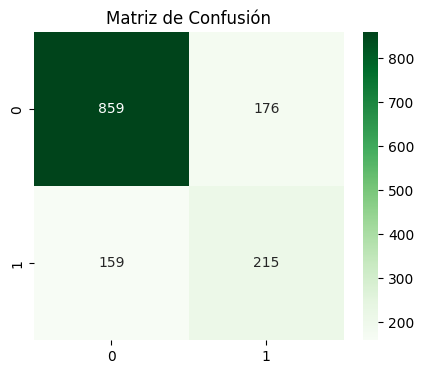

In [1]:
# CONSTRUCCION DE UN UNICO MODELO PREDICTIVO

import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Carga Inteligente ---
if 'df_raw' not in locals():
    print("Descargando datos...")
    url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
    df_raw = pd.json_normalize(requests.get(url).json())

# --- 2. Preparación Rápida ---
df_model = df_raw.copy()
col_target = [c for c in df_model.columns if 'churn' in c.lower()][0]

# Limpieza y mapeo directo
df_model[col_target] = df_model[col_target].astype(str).str.strip().str.lower()
df_model['target'] = df_model[col_target].map({'yes': 1, 'no': 0})
df_model = df_model.dropna(subset=['target'])

# --- 3. Ingeniería de Variables Eficiente ---
# Eliminamos columnas que tengan más de 100 valores únicos si son texto (IDs)
X = df_model.drop(columns=[col_target, 'target'], errors='ignore')
y = df_model['target'].astype(int)

cols_to_drop = [c for c in X.columns if X[c].dtype == 'object' and X[c].nunique() > 100]
X = X.drop(columns=cols_to_drop + ['customerID'], errors='ignore')

# One-Hot Encoding y rellenar nulos
X = pd.get_dummies(X, drop_first=True).fillna(0)

# --- 4. Selección de Variables Veloz ---
# Calculamos correlación SOLO contra la variable 'y'
print("Calculando relevancia de variables...")
relevancia = X.corrwith(y).abs().sort_values(ascending=False)
selected_features = relevancia[relevancia > 0.05].index.tolist()
X_selected = X[selected_features]

# --- 5. Pipeline de Modelado ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Balanceo y Escalado
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento
print("Entrenando modelo...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 usa todos los núcleos
model.fit(X_train_scaled, y_train_bal)

# --- 6. Resultados ---
y_pred = model.predict(X_test_scaled)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión simplificada
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión")
plt.show()


/tmp/ipython-input-1456316804.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


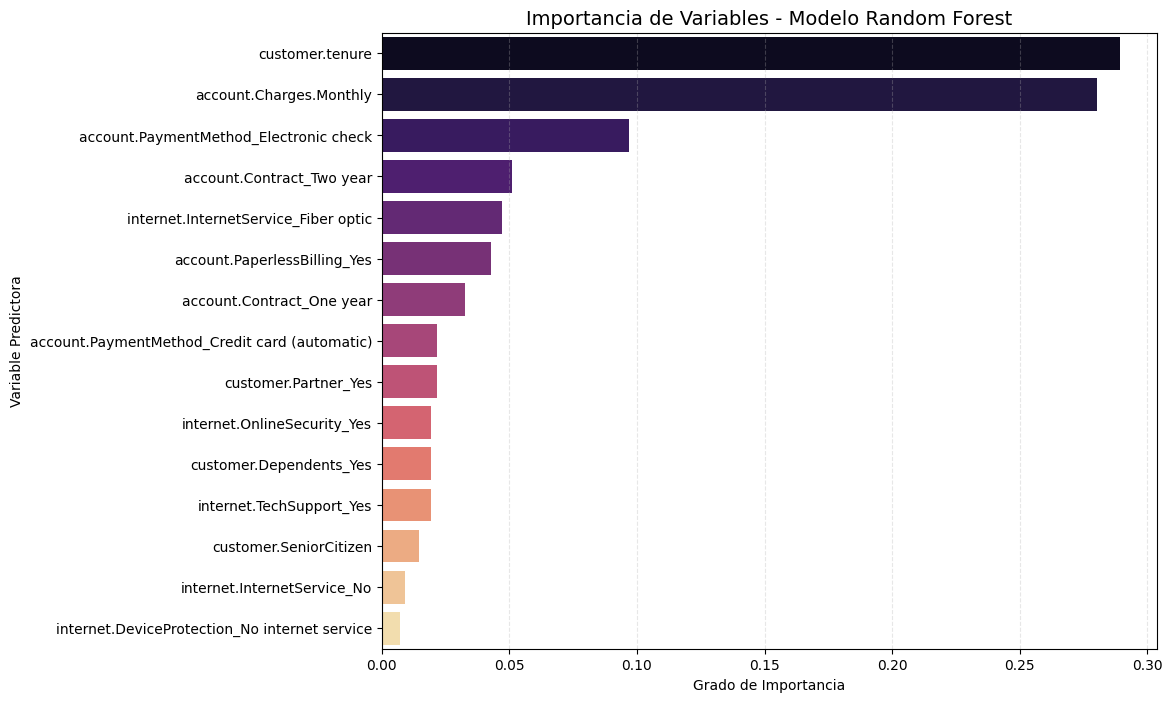

¡Éxito! El modelo ha sido entrenado y la importancia visualizada.


In [10]:
# ANALISIS DE IMPORTANCIA DE LAS VARIABLES

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- PASO DE SEGURIDAD: Asegurar que X e y existan antes de procesar ---
# Usamos las variables que definimos en los pasos de limpieza anteriores
try:
    # 1. Selección de variables (Usamos las que tienen correlación significativa)
    # Si X_selected no existe, la creamos aquí rápidamente
    if 'X_selected' not in locals():
        # Tomamos las columnas numéricas disponibles en X
        X_selected = X.copy()

    # 2. División train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. Balanceo con SMOTE
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

    # 4. Escalado (Aquí se crea la variable del error)
    scaler = StandardScaler()
    X_train_bal_scaled = scaler.fit_transform(X_train_bal)
    X_test_scaled = scaler.transform(X_test)

    # 5. Definir y entrenar el modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_bal_scaled, y_train_bal)

    # 6. Extraer importancia de las variables
    importances = model.feature_importances_
    feature_names = X_selected.columns

    # 7. Crear DataFrame ordenado
    df_importance = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False)

    # 8. Visualización gráfica
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='Importancia',
        y='Variable',
        data=df_importance.head(15),
        palette='magma'
    )
    plt.title("Importancia de Variables - Modelo Random Forest", fontsize=14)
    plt.xlabel("Grado de Importancia")
    plt.ylabel("Variable Predictora")
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.show()

    print("¡Éxito! El modelo ha sido entrenado y la importancia visualizada.")

except Exception as e:
    print(f"Error detectado: {e}")
    print("Asegúrate de haber ejecutado la celda donde se definen 'X' y 'y' antes de esta.")


In [ ]:
# Interpretación de la importancia

Las variables con mayor importancia son las que más contribuyen a predecir si un cliente va a cancelar.

Por ejemplo, podríamos encontrar que:

- MonthlyCharges (cargos mensuales) → clientes con pagos altos podrían estar más propensos a cancelar.

- tenure (antigüedad) → clientes con menos tiempo podrían irse más rápido.

- Contract_Month-to-month → contratos mensuales tienen más riesgo de churn que contratos anuales.

- InternetService_Fiber optic → algunos servicios específicos pueden generar más cancelaciones.

# Conclusión y recomendaciones para la empresa

1. Segmentación de clientes de riesgo

Identificar clientes con alto MonthlyCharges y contratos mensuales para ofrecerles planes más atractivos o descuentos.

2. Programas de fidelización

Clientes con baja antigüedad (tenure) podrían recibir beneficios tempranos, como promociones o atención personalizada.

3. Mejorar servicios específicos

Si ciertos servicios como Internet Fiber tienen alta correlación con churn, investigar problemas de calidad o soporte técnico.

4. Ofertas personalizadas

Basado en el perfil de riesgo, ofrecer actualizaciones de contrato o paquetes personalizados antes de que decidan cancelar.

Con esto, la empresa puede anticiparse a la evasión, enfocando recursos en clientes con mayor riesgo de cancelación, en lugar de aplicar estrategias generales a todos.